In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q wandb

     |████████████████████████████████| 1.9 MB 36.2 MB/s 
     |████████████████████████████████| 168 kB 71.3 MB/s 
     |████████████████████████████████| 182 kB 66.0 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 168 kB 64.8 MB/s 
     |████████████████████████████████| 166 kB 75.2 MB/s 
     |████████████████████████████████| 166 kB 77.3 MB/s 
     |████████████████████████████████| 162 kB 73.3 MB/s 
     |████████████████████████████████| 162 kB 74.8 MB/s 
     |████████████████████████████████| 158 kB 79.7 MB/s 
     |████████████████████████████████| 157 kB 79.1 MB/s 
     |████████████████████████████████| 157 kB 74.6 MB/s 
     |████████████████████████████████| 157 kB 79.9 MB/s 
     |████████████████████████████████| 157 kB 78.4 MB/s 
     |████████████████████████████████| 157 kB 81.2 MB/s 
     |████████████████████████████████| 157 kB 75.9 MB/s 
     |████████████████████████████████| 157 kB 74.3 MB/s 
     |██████████

In [ ]:
!nvidia-smi

Tue Nov 29 19:34:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os

from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision
import torchvision.transforms as tt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import PIL
from PIL import Image

from glob import glob
from PIL import Image
import cv2 as cv
 
%matplotlib inline

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
# OLD broken dataset
#!unzip 'data.zip'

# ORIGINAL toadbox dataset
# !cp toadbox/ all -r
# !unzip -q 'toadbox.zip'

# TOADBOX_2 dataset
# !cp /content/drive/MyDrive/toadbox_2.zip .
# !unzip -q toadbox_2.zip
# !mv toadbox_2 toadbox

# TOADBOX_2 CROPPED
!cp /content/drive/MyDrive/toadbox_crop.zip .
!unzip -q toadbox_crop.zip
!mv toadid_crop toadbox

In [ ]:
!rm -r toadbox/t0

In [ ]:
!ls 

drive  sample_data  toadbox  toadbox_crop.zip


In [ ]:
import random

def test_split(path='toadbox/', test_path='test_split/', test_ratio=0.2):
    os.system(f'rm -r {test_path}')
    os.mkdir(test_path)

    for root, dirs, files in os.walk(path):
        os.mkdir(os.path.join(test_path, root))

        n = int(len(files) * test_ratio)
        test = random.sample(files, n)

        for impath in test:
            impath = os.path.join(root, impath)
            os.system(f'mv {impath} test_split/{impath}')


def test_split_separate(path='toadbox/', test_path='test_split/', test_ratio=0.2):
    os.system(f'rm -r {test_path}')
    os.mkdir(test_path)

    toad_dirs = os.listdir(path)    
    random.shuffle(toad_dirs)
    n = int(len(toad_dirs) * test_ratio)
    
    for dir in toad_dirs[:n]:
        os.system(f'mv {os.path.join(path, dir)} {os.path.join(test_path, dir)}')

# test_split(test_ratio=0.2)
test_split_separate(test_ratio=0.2)

In [ ]:
!echo images
!ls toadbox/*/* | wc -l
!ls test_split/*/* | wc -l

images
1309
332


In [ ]:
!ls -l all | wc -l

ls: cannot access 'all': No such file or directory
0


In [ ]:
!echo toad folders
!ls -l toadbox | wc -l
!ls -l test_split | wc -l

toad folders
61
16


In [ ]:
!ls

drive  sample_data  test_split	toadbox  toadbox_crop.zip


In [ ]:
class DotDict(dict):
    def __getattr__(self, attr):
        return self.get(attr)
 
    def __setattr__(self, key, value):
        self.__setitem__(key, value)
 
config = DotDict()
config.image_size = 224
config.num_classes = 40
config.batch_size = 48
config.epochs = 300
config.lr = 1e-4
config.lr2= 5e-6
config.momentum = 0.9
config.train_p = 0.80

config.rotate = 15
config.fill = 248
config.perspective = 0.3
config.sharpness = 0.9
config.contrast = 0.3

In [ ]:
!ls toadbox

2_t0   2_t13  2_t2   2_t24  2_t29  2_t5  t11  t16  t22	t28  t32  t38
2_t1   2_t14  2_t20  2_t25  2_t30  2_t7  t12  t17  t24	t29  t34  t39
2_t10  2_t15  2_t21  2_t26  2_t33  2_t9  t13  t19  t25	t3   t35  t5
2_t11  2_t16  2_t22  2_t27  2_t34  t1	 t14  t20  t26	t30  t36  t6
2_t12  2_t19  2_t23  2_t28  2_t4   t10	 t15  t21  t27	t31  t37  t7


In [ ]:
!ls test_split

2_t17  2_t3   2_t32  2_t6  t18	t23  t4  t9
2_t18  2_t31  2_t35  2_t8  t2	t33  t8


In [ ]:
DS_PATH = 'toadbox/'
VALID_PATH = 'test_split/'
ALL_PATH = 'all/'
# imagenet
STATS = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

In [ ]:
!mkdir $ALL_PATH
!cp -r $DS_PATH/* $ALL_PATH
!cp -r $VALID_PATH/* $ALL_PATH

In [ ]:
import torchvision.transforms.functional as ff
from PIL import Image
import random

def centerScale(min=.22, max=.35):
    def func(img):
        H, W = img.size
        scale = random.uniform(min, max)
        h = scale*H
        w = scale*W 
        t = (H - h) / 2
        l = (W - w) / 2

        img = ff.crop(img, t, l, h, w)
        return img
    return func
'''
import albumentations as A
def clahe(clip_limit=20, tile_grid_size=(80,80)):
    def func(img):
        return Image.fromarray(A.clahe(np.array(img), clip_limit=clip_limit, tile_grid_size=tile_grid_size))
    return func
''' ;

In [ ]:
def multipleErrase(n, p):
    queue = []
    for i in range(n):
        queue.append(tt.RandomErasing(p=p, scale=(0.001, 0.008),
                                      ratio=(0.7, 1.8), value=0, inplace=True))
    func = tt.Compose(queue)
    return func

In [ ]:
transform=tt.Compose([
    #TODO AutoAugmentPolicy
                    tt.RandomRotation(config.rotate, fill=config.fill),
                    tt.RandomPerspective(config.perspective, fill=config.fill),
                    tt.RandomAdjustSharpness(config.sharpness),
                    tt.RandomAutocontrast(config.contrast),
                    ## centerScale(),
                    tt.ColorJitter(0.4, 0.2, 0.1, 0.08),
                    ## tt.AutoAugment(tt.autoaugment.AutoAugmentPolicy.IMAGENET),
                    tt.Resize((config.image_size, config.image_size)),
                    ## clahe(),
                    tt.ToTensor(),
                    multipleErrase(12, 0.8),
                    ## tt.Normalize(*STATS)
                 ])

transform_test=tt.Compose([
                    #centerScale(.28, .28),
                    tt.Resize((config.image_size, config.image_size)),
                    #clahe(),
                    tt.ToTensor(),
])

imfolder_ds = ImageFolder(DS_PATH, transform=transform)
imfolder_dl = DataLoader(imfolder_ds, config.batch_size, shuffle=True)

TOTAL_COUNT = len(imfolder_ds)

In [ ]:
!ls $DS_PATH

2_t0   2_t13  2_t2   2_t24  2_t29  2_t5  t11  t16  t22	t28  t32  t38
2_t1   2_t14  2_t20  2_t25  2_t30  2_t7  t12  t17  t24	t29  t34  t39
2_t10  2_t15  2_t21  2_t26  2_t33  2_t9  t13  t19  t25	t3   t35  t5
2_t11  2_t16  2_t22  2_t27  2_t34  t1	 t14  t20  t26	t30  t36  t6
2_t12  2_t19  2_t23  2_t28  2_t4   t10	 t15  t21  t27	t31  t37  t7


In [ ]:
valid_ds = ImageFolder(VALID_PATH, transform=transform_test)
valid_dl = DataLoader(valid_ds, config.batch_size, shuffle=True)

In [ ]:
classes, idx = zip(*valid_ds.class_to_idx.items())
idx_class_dict = dict(zip(idx, classes))

tensor([ 4,  5,  0, 10, 12,  5, 10, 13,  5,  1,  5,  5, 10,  6,  7, 14,  0,  6,
         2, 14,  9,  1,  3,  1, 14,  4,  7,  6,  1,  9,  3, 11, 14,  5,  0,  0,
         4,  7,  0, 12,  3,  6, 10, 10,  8,  4,  1, 12])


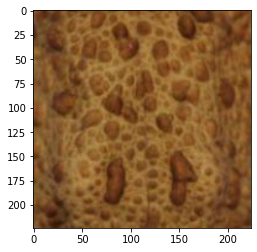

In [ ]:
l = next(iter(valid_dl))

print(l[1])


for i in l[0]:
    plt.imshow(i.permute(1,2,0))
    #plt.show()

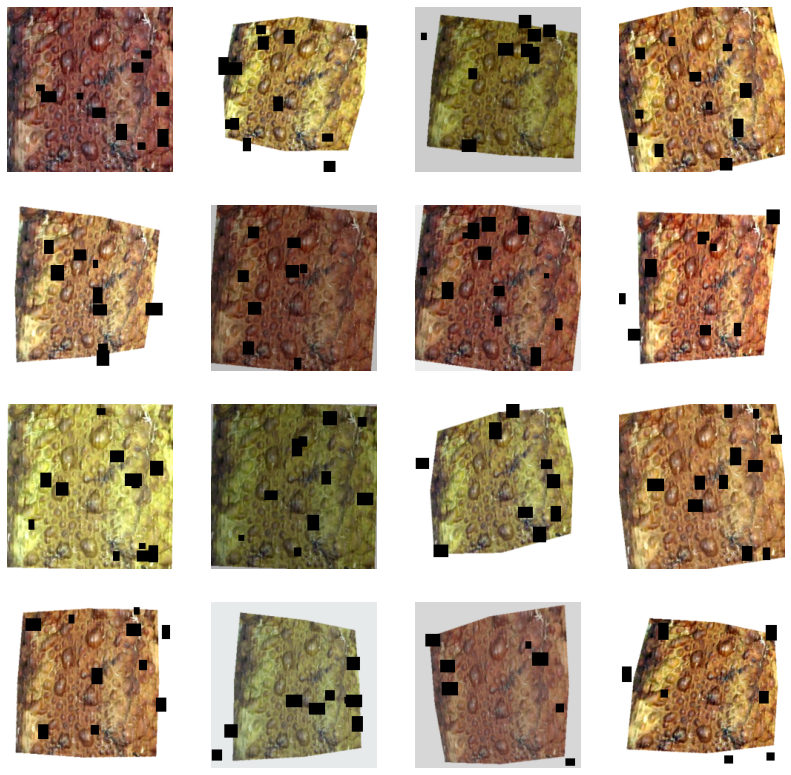

In [ ]:
plt.figure(figsize=(14,14))
for i in range(16):
    plt.subplot(4,4,1+i)
    plt.imshow(imfolder_ds[30][0].permute(1,2,0))
    plt.axis('off')
plt.show()

In [ ]:
import torchvision

class Siamese(nn.Module):
    def __init__(self, latent=32, mode='triplet', pretrained=True):
        super().__init__()
        self.mode = mode
        self.backbone = torchvision.models.resnet101(pretrained=pretrained)
        self.backbone.fc = nn.Identity()

        for param in self.backbone.parameters():
            param.requires_grad = False

        self.fc = nn.Linear(2048, latent)

    def forward_single(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x

    def forward(self, left, right, neg=None):
        if self.mode == 'pair':
            left = self.forward_single(left)
            right = self.forward_single(right)
            return left, right
        elif self.mode == 'triplet':
            if neg == None:
                raise ValueError('Provide negative for triplet loss')
            a = self.forward_single(left)
            p = self.forward_single(right)
            n = self.forward_single(neg)
            return a, p, n

In [ ]:
model = Siamese(512)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [ ]:
for p in model.backbone.layer4.parameters():
    p.requires_grad = False
for p in model.backbone.layer3.parameters():
    p.requires_grad = False

In [ ]:
#model.load_state_dict(torch.load('/content/drive/MyDrive/toad-siam-65.pth'))

In [ ]:
def show(tens):
    if len(tens.shape) == 3:
        tens = tens.unsqueeze(0)
    l = tens.shape[0]
    plt.figure(figsize=(4*l,4))
    if l > 8: l = 8
    for i, t in enumerate(tens):
        if i == l: break
        plt.subplot(1, l, 1+i)
        plt.imshow(t.permute(1,2,0))
        plt.axis('off')
    plt.show()

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """
 
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
 
    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
 
        return loss_contrastive

## Обучение и сбор метрик

In [ ]:
from glob import glob

def visualize_dataset(data_path):
    class_folder = np.array(glob(f'./{data_path}/*/*'))
    p = np.random.choice(class_folder, 5*5)
    plt.figure(figsize=(12,12))
    for i, im_p in enumerate(p):
        img = transform_test(Image.open(im_p)).permute(1,2,0)
        plt.subplot(5, 5, 1+i)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

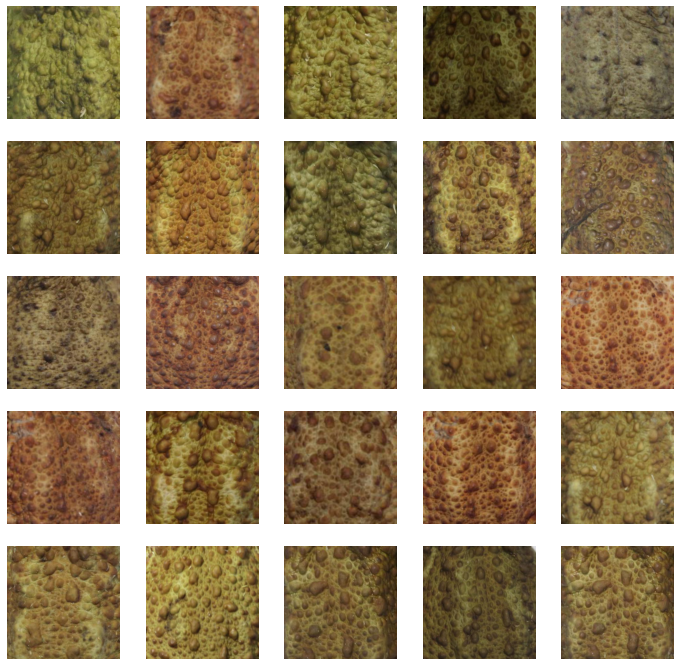

In [ ]:
visualize_dataset('toadbox')

In [ ]:
def bake_embeddings(model, path=DS_PATH, transform=transform_test):
    """
    Returns a dictionary of computed embeddings for the directory given
    """
    baked = {}

    model.eval()
    model.to(device)

    print('Baking embeddings!')
    count = len(list(os.walk(path)))
    for i, (dp, dn, fnames) in tqdm(enumerate(os.walk(path)), total=count, leave=False):
        folder = dp.split('/')[-1]
        if folder == '':
            continue
        refs = []
        with torch.no_grad():
            names = list(map(lambda n: os.path.join(dp, n), fnames))
            for name in names:
                ref = transform(Image.open(name)).unsqueeze(0).to(device)
                with torch.cuda.amp.autocast():
                    ref = model.forward_single(ref).cpu()
                refs.append((name, ref))
        baked[folder] = refs

    model.cpu()
    return baked

In [ ]:
def bake_distance(sample, baked, mask=False, sample_path=None):
    dists = {}
    for i, (folder, embeddings) in enumerate(baked.items()):
        dists[folder] = [(pair[0], torch.dist(sample, pair[1]).item()) for pair in embeddings]
    # mask exact matches
    if mask:
        for k in dists:
            source_dists = dists[k]
            filtered_dists = []
            for source_path, d in source_dists:
                if sample_path == source_path: continue
                filtered_dists.append((source_path, d))
            dists[k] = filtered_dists
    return dists

In [ ]:
def siam_rank(model, baked_dist, sample, kind='median', isImage=False):
    """
    Returns sorted list of tuples ranking predictions for sample
    compared to baked embeddings with different criterion.
    """
    model.eval()
    model.to(device)
    if not isImage:
        sample = transform_test(Image.open(sample))
    else:
        sample = transform_test(sample)
    sample = sample.unsqueeze(0).to(device)
    with torch.no_grad():
        sample = model.forward_single(sample).squeeze().cpu()

    ranking = {}
    for folder, name_dist in baked_dist.items():
        dist = [p[1] for p in name_dist]
        if kind == 'mean':
            dist = np.mean(dist)
        elif kind == 'min':
            dist = min(dist)
        elif kind == 'max':
            dist = max(dist)
        elif kind == 'median':
            dist = np.median(dist)
        elif kind == 'min_fair':
            dist = sorted(dist)[1]
        else:
            raise ValueError()

        ranking[folder] = dist

    ranking = sorted(ranking.items(), key=lambda x: x[1])
    model.cpu()
    return ranking

In [ ]:
import random
def mine_hardneg(baked_dist, sample_path, kind='mean', k=5, hardness='semihard'):
    """
    Returns sorted list of hard/semi-hard negative for the sample given
    """
    positive_class = sample_path.split('/')[-2]

    negatives = []
    positives = []

    for name, pairs in baked_dist.items():
        if name == positive_class:
            positives += pairs
        else:
            negatives += pairs
    positives = [p[1] for p in positives]
    threshold = 0
    if kind == 'mean':
        threshold = np.mean(positives)
    elif kind == 'min':
        threshold = min(positives)
    elif kind == 'max':
        threshold = max(positives)
    elif kind == 'median':
        threshold = np.median(positives)
    elif kind == 'min_fair':
        threshold = sorted(positives)[1]
    else:
        raise ValueError()

    negatives = sorted(negatives, key=lambda x: x[1])

    if hardness == 'semihard':
        i = 0
        for n in negatives:
            if n[1] > threshold:
                break
            i += 1
        selected = negatives[i:i+k]
        if len(selected) == 0: selected = negatives[:k]
    elif hardness == 'hard':
        selected = negatives[:k]
        

    return selected

In [ ]:
def show_path(path):
    plt.figure(figsize=(10,5))
    i = Image.open(path)
    plt.subplot(121)
    plt.imshow(i)
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(transform_test(i).permute(1,2,0))
    plt.show()

In [ ]:
def infere_path(model, sample_path, transform=transform_test):
    model.eval().to(device)
    sample = transform(Image.open(sample_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        sample = model.forward_single(sample).cpu()
    model.cpu()
    return sample

In [ ]:
def infere_img(model, sample_img, transform=transform_test):
    model.eval().to(device)
    sample = transform(sample_img).unsqueeze(0).to(device)
    with torch.no_grad():
        sample = model.forward_single(sample).cpu().squeeze(0)
    model.cpu()
    return sample

In [ ]:
#baked = bake_embeddings(model)

In [ ]:
'''
import pickle
dump = open('/content/drive/MyDrive/baked.pkl', 'wb')
pickle.dump(baked, dump)

!ls /content/drive/MyDrive/baked.pkl
''' ;

In [ ]:
# t = '/content/all/t15/IMG_8698.JPG'

# sample = infere_path(model, t)
 
# show_path(t)
# baked_dist = bake_distance(sample, baked)
# rank = siam_rank(model, baked_dist, t)
# hardnegs = mine_hardneg(baked_dist, t)
# rank[:5], hardnegs[:5]

In [ ]:
# for x in [n[0] for n in hardnegs[:5]]:
#     show_path(x)

In [ ]:
def siam_score(model, baked_source, baked_target, kind='median', mask=False):
    top1 = 0
    top2 = 0
    top3 = 0
    top5 = 0
    top10= 0
    count = 0
    print('Scoring model!')
    # TODO use sklearn.metrics.pairwise : cosine_similarity, l2
    for cl_name, path_vect in tqdm(baked_target.items(), leave=False):
        for pv in path_vect:
            sample_path = pv[0]  
            vect = pv[1]
            baked_dist = bake_distance(vect, baked_source, mask=mask, sample_path=sample_path)
            rank = siam_rank(model, baked_dist, sample_path, kind=kind)
            rank1 = rank[:1]
            rank2 = rank[:2]
            rank3 = rank[:3]
            rank5 = rank[:5]
            rank10= rank[:10]

            occ1 = [e[0] for e in rank1]
            occ2 = [e[0] for e in rank2]
            occ3 = [e[0] for e in rank3]
            occ5 = [e[0] for e in rank5]
            occ10= [e[0] for e in rank10]

            if cl_name in occ1: top1 += 1
            if cl_name in occ2: top2 += 1
            if cl_name in occ3: top3 += 1
            if cl_name in occ5: top5 += 1
            if cl_name in occ10:top10+= 1

            count += 1
    top1 /= count
    top2 /= count
    top3 /= count
    top5 /= count
    top10/= count
    return top1, top2, top3, top5, top10

In [ ]:
import random

class SiameseDS(Dataset):
    def __generate_names(self):
        for i, (dp, dn, fnames) in enumerate(os.walk(self.path)):
            folder = dp.split('/')[-1]
            if folder == '':
                continue

            names = list(map(lambda n: os.path.join(dp, n), fnames))
            self.names[folder] = names

    def generate_pairs(self, baked=None):
        if baked is None:
            baked = bake_embeddings(model, self.path)

        if self.mode == 'pair':
            pairs_pos = []
            pairs_neg = []
            classes = list(self.names.keys())
            print('Baking pairs!')
            for l in trange(0, self.len):
                for cl in classes:
                    pclass = cl
                    files = self.names[pclass]

                    left = right = ''
                    while left == right:
                        left = np.random.choice(files)
                        right = np.random.choice(files)
                    pairs_pos.append((left, right))

                    assert self.hardness != 'random', 'random hardness not implemented for pairs'
                    while pclass == cl:
                        pclass = np.random.choice(classes)
                    l_path, l_vect = random.choice(baked[cl])
                    baked_dist = bake_distance(l_vect, baked)
                    hardnegs = mine_hardneg(baked_dist, l_path, hardness=self.hardness)
                    right, _ = random.choice(hardnegs)
                    pairs_neg.append((l_path, right))
            self.pairs = pairs_neg + pairs_pos

        if self.mode == 'triplet':
            triplets = []
            classes = list(self.names.keys())
            print('Baking triplets!')
            for l in trange(0, self.len):
                for cl in classes:
                    files = self.names[cl]

                    # triplets can be implemented
                    anchor, anchor_vect = random.choice(baked[cl])
                    pos = anchor
                    while anchor == pos:
                        pos = np.random.choice(files)

                    neg_class = cl                    
                    while neg_class == cl:
                        neg_class = np.random.choice(classes)

                    if self.hardness == 'random':
                        neg = random.choice(baked[neg_class])[0]
                    else:
                        baked_dist = bake_distance(anchor_vect, baked)
                        hardnegs = mine_hardneg(baked_dist, anchor, hardness=self.hardness)
                        neg, _ = random.choice(hardnegs)
                    triplets.append((anchor, pos, neg))
            self.pairs = triplets

        random.shuffle(self.pairs)
        
    def __init__(self, path, model, len, transform, dummy=False, mode='triplet', hardness='semihard'):
        super().__init__()
        self.len = len
        self.names = {}
        self.pairs = []
        self.path = path
        self.transform = transform
        self.mode = mode
        self.hardness = hardness

        if not dummy:
            self.__generate_names()
            self.generate_pairs()

    def __len__(self): return self.len
    def __getitem__(self, idx):
        if self.mode == 'pair':
            left, right = self.pairs[idx]
            label = left.split('/')[-2] != right.split('/')[-2]

            left = self.transform(Image.open(left))
            right = self.transform(Image.open(right))

            return left, right, float(label)

        elif self.mode == 'triplet':
            anchor, pos, neg = self.pairs[idx]


            anchor = self.transform(Image.open(anchor))
            pos = self.transform(Image.open(pos))
            neg = self.transform(Image.open(neg))

            return anchor, pos, neg
        else:
            raise ValueError('Invalid mode')

In [ ]:
'''
siam_dl = DataLoader(siam_ds, batch_size=4, shuffle=True)

d = next(iter(siam_dl))
d[0].squeeze(0).shape
show(d[0])
show(d[1])
show(d[2])
d[0].shape
''' ;

In [ ]:
config.lr

0.0001

In [ ]:
#baked = bake_embeddings(model)
#baked_test = bake_embeddings(model, path=VALID_PATH)
#accs = siam_score(model, baked, baked_test, kind='mean')

In [ ]:
def train(model, siam_ds, epochs, opt, loss_fn, sched, mining_period=5, scaler=None, validate=False, batch_size=config.batch_size, ignore_first=False):
    siam_dl = DataLoader(siam_ds, batch_size=batch_size, shuffle=True)
    best_1_acc = 0
    best_1_acc_all = 0
    for i in trange(epochs):
        if i % mining_period == 0 and not (ignore_first and i == 0):
            baked = bake_embeddings(model, transform=transform)
            train_accs = siam_score(model, baked, baked, kind='mean')
            if validate:
                baked_all = bake_embeddings(model, path=ALL_PATH, transform=transform)
                baked_test = bake_embeddings(model, path=VALID_PATH, transform=transform)
                valid_accs = siam_score(model, baked_test, baked_test, kind='mean', mask=True)
                valid_accs_all = siam_score(model, baked_all, baked_test, kind='mean', mask=True)
                if valid_accs[0] > best_1_acc:
                    torch.save(model.state_dict(), 'best_model.pt')
                    best_1_acc = valid_accs[0]
                if valid_accs_all[0] > best_1_acc_all:
                    torch.save(model.state_dict(), 'best_model_all.pt')
                    best_1_acc_all = valid_accs_all[0]


        
            accs = [1, 2, 3, 5, 10]
            # wandb
            metrics = {}

            for j, a in enumerate(accs):
                metrics[f'train_{a}_acc'] = train_accs[j]
                if validate:
                    metrics[f'valid_{a}_acc'] = valid_accs[j]
                    metrics[f'valid_{a}_acc_all'] = valid_accs_all[j]
            wandb.log(metrics)

            siam_ds.generate_pairs(baked)
            siam_dl = DataLoader(siam_ds, batch_size=batch_size, shuffle=True)
        
        model.train()
        model.to(device)
        epoch_loss = 0
        for A, P, N in tqdm(siam_dl, leave=False):
            A = A.to(device)
            P = P.to(device)
            N = N.to(device)
            opt.zero_grad()
            if scaler is not None:
                with torch.cuda.amp.autocast():
                    a, p, n = model(A, P, N)
            else:
                a, p, n = model(A, P, N)

            loss = loss_fn(a, p, n)

            # step
            if scaler is not None:
                scaler.scale(loss).backward()
                scaler.unscale_(opt)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(opt)
                scaler.update()
            else:
                loss.backward()
                opt.step()
            
            epoch_loss += loss.item()
    
            # wandb
            
            metrics = {}
            metrics['train_loss'] = loss.item()
            #metrics['train_accuracy'] = acc
            #metrics['lr'] = sched.get_last_lr()
            wandb.log(metrics)
    
        epoch_loss = epoch_loss / len(siam_ds)
        sched.step(epoch_loss)

        metrics = {}
        metrics['train_epoch_loss'] = epoch_loss
        metrics['lr'] = opt.param_groups[0]['lr']
        wandb.log(metrics)

        print(f'epoch {i} loss: {epoch_loss}')
        train_loss.append(epoch_loss)

In [ ]:
# idx = 0
# baked['t1'][idx][0]

In [ ]:
model = Siamese(512)
siam_ds = SiameseDS(DS_PATH, model, 10000, transform, hardness='random')

train_loss = []

model.to(device)
opt = torch.optim.Adam(model.parameters(), config.lr)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=2, )
scaler = torch.cuda.amp.GradScaler()
'''
sched = optim.lr_scheduler.OneCycleLR(opt, config.lr,
                                        epochs=config.epochs, 
                                        steps_per_epoch=len(siam_dl))
'''
loss_fn = nn.TripletMarginLoss()

Baking embeddings!


  0%|          | 0/61 [00:00<?, ?it/s]

Baking triplets!


  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
!echo alive

alive


In [ ]:
import wandb
wandb.init(project='ToadID-new', config=config)
wandb.watch(model, log_freq=100)
!wandb online

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


W&B online. Running your script from this directory will now sync to the cloud.


In [ ]:
!echo alive

alive


In [ ]:
train(model, siam_ds, 1, opt, loss_fn, sched, mining_period=5, scaler=scaler, batch_size=512)

  0%|          | 0/1 [00:00<?, ?it/s]

Baking embeddings!


  0%|          | 0/61 [00:00<?, ?it/s]

Scoring model!


  0%|          | 0/60 [00:00<?, ?it/s]

Baking triplets!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 0 loss: 0.0010363525390625


In [ ]:
for p in model.parameters():
    p.requires_grad = True

opt = torch.optim.Adam(model.parameters(), config.lr2)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)

baked = bake_embeddings(model)
siam_ds.generate_pairs(baked)
print('alive-alive')
train(model, siam_ds, 16, opt, loss_fn, sched, mining_period=2, scaler=scaler, validate=True)

Baking embeddings!


  0%|          | 0/61 [00:00<?, ?it/s]

Baking triplets!


  0%|          | 0/10000 [00:00<?, ?it/s]

alive-alive


  0%|          | 0/16 [00:00<?, ?it/s]

Baking embeddings!


  0%|          | 0/61 [00:00<?, ?it/s]

Scoring model!


  0%|          | 0/60 [00:00<?, ?it/s]

Baking embeddings!


  0%|          | 0/76 [00:00<?, ?it/s]

Baking embeddings!


  0%|          | 0/16 [00:00<?, ?it/s]

Scoring model!


  0%|          | 0/15 [00:00<?, ?it/s]

Scoring model!


  0%|          | 0/15 [00:00<?, ?it/s]

Baking triplets!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch 0 loss: 0.004434974670410157


  0%|          | 0/209 [00:00<?, ?it/s]

epoch 1 loss: 0.0019096839904785155
Baking embeddings!


  0%|          | 0/61 [00:00<?, ?it/s]

Scoring model!


  0%|          | 0/60 [00:00<?, ?it/s]

Baking embeddings!


  0%|          | 0/76 [00:00<?, ?it/s]

Baking embeddings!


  0%|          | 0/16 [00:00<?, ?it/s]

Scoring model!


  0%|          | 0/15 [00:00<?, ?it/s]

Scoring model!


  0%|          | 0/15 [00:00<?, ?it/s]

Baking triplets!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch 2 loss: 0.0012121731519699097


  0%|          | 0/209 [00:00<?, ?it/s]

epoch 3 loss: 0.0008205649614334106
Baking embeddings!


  0%|          | 0/61 [00:00<?, ?it/s]

Scoring model!


  0%|          | 0/60 [00:00<?, ?it/s]

Baking embeddings!


  0%|          | 0/76 [00:00<?, ?it/s]

Baking embeddings!


  0%|          | 0/16 [00:00<?, ?it/s]

Scoring model!


  0%|          | 0/15 [00:00<?, ?it/s]

Scoring model!


  0%|          | 0/15 [00:00<?, ?it/s]

Baking triplets!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch 4 loss: 0.0006265283226966858


  0%|          | 0/209 [00:00<?, ?it/s]

epoch 5 loss: 0.0004890295028686523
Baking embeddings!


  0%|          | 0/61 [00:00<?, ?it/s]

Scoring model!


  0%|          | 0/60 [00:00<?, ?it/s]

Baking embeddings!


  0%|          | 0/76 [00:00<?, ?it/s]

Baking embeddings!


  0%|          | 0/16 [00:00<?, ?it/s]

Scoring model!


  0%|          | 0/15 [00:00<?, ?it/s]

Scoring model!


  0%|          | 0/15 [00:00<?, ?it/s]

Baking triplets!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

epoch 6 loss: 0.0003974280059337616


  0%|          | 0/209 [00:00<?, ?it/s]

epoch 7 loss: 0.0003835474133491516
Baking embeddings!


  0%|          | 0/61 [00:00<?, ?it/s]

Scoring model!


  0%|          | 0/60 [00:00<?, ?it/s]

Baking embeddings!


  0%|          | 0/76 [00:00<?, ?it/s]

Baking embeddings!


  0%|          | 0/16 [00:00<?, ?it/s]

Scoring model!


  0%|          | 0/15 [00:00<?, ?it/s]

Scoring model!


  0%|          | 0/15 [00:00<?, ?it/s]

Baking triplets!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
!ls best_model*
!cp best_model*  '/content/drive/MyDrive/'

best_model_all.pt  best_model.pt


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/toadid_new_30_11_2022.pth')

In [ ]:
wandb.run.finish()

lr,█▁▁▁▁▁▁▁▁
train_10_acc,▁▆████
train_1_acc,▁▅▇███
train_2_acc,▁▆▇███
train_3_acc,▁▆████
train_5_acc,▁▆████
train_epoch_loss,▂█▄▂▂▁▁▁▁
train_loss,█▄▅▃▂▅▂▂▂▂▁▂▁▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
valid_10_acc,▁████
valid_10_acc_all,▁▇███
valid_1_acc,▁▆▇██


In [ ]:
torch.save(model.state_dict(), 'ckp.pt')

In [ ]:
EPSILON = 0.00005

#baked_test = bake_embeddings(model, path=VALID_PATH)

for cl_name, path_vect in tqdm(baked_test.items()):
        for pv in path_vect:
            sample_path = pv[0]  
            vect = pv[1]
            baked_dist = bake_distance(vect, baked_test)
            for k in baked_dist:
                dists = baked_dist[k]
                for source_path, d in dists:
                    if sample_path == source_path:
                        continue

In [ ]:
accs = siam_score(model, baked_test, baked_test, kind='mean')

In [ ]:
metrics = {}
for j, a in enumerate(accs):
    metrics[f'valid_{a}_acc'] = accs[j]
wandb.log(metrics)

## Score

In [ ]:
# model = Siamese(512)

In [ ]:
import sklearn.manifold

def plot_tsne(model, ds_path, additional=None, transform=transform):
    ts = sklearn.manifold.TSNE()

    imfolder_ds = ImageFolder(ds_path, transform=transform)
    baked = bake_embeddings(model, path=ds_path, transform=transform)

    lbls = [imfolder_ds.class_to_idx[p[0].split('/')[-2]] for toad in baked.values() for p in toad]
    embeddings = [p[1].squeeze().numpy() for toad in baked.values() for p in toad]

    if additional:
        lbls.extend([-100]*len(additional))
        embeddings.extend(additional)

    reduced = ts.fit_transform(embeddings)

    plt.figure(figsize=(16,16))
    scatter = plt.scatter(reduced[:,0], reduced[:,1], c=lbls, cmap='tab20', label=lbls)

    offset = 5
    checked = set()
    for i in range(0, len(reduced[:,0])):
        if lbls[i] == -100:
            plt.text(reduced[i,0], reduced[i,1], f'*')
            continue
        if lbls[i] not in checked:
            plt.text(reduced[i,0], reduced[i,1], f'{lbls[i]}')
            checked.add(lbls[i])
    

    plt.title(f'{ds_path} embeddings t-SNE projection')
    plt.legend(*scatter.legend_elements())
    plt.show()

Baking embeddings!


  0%|          | 0/61 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


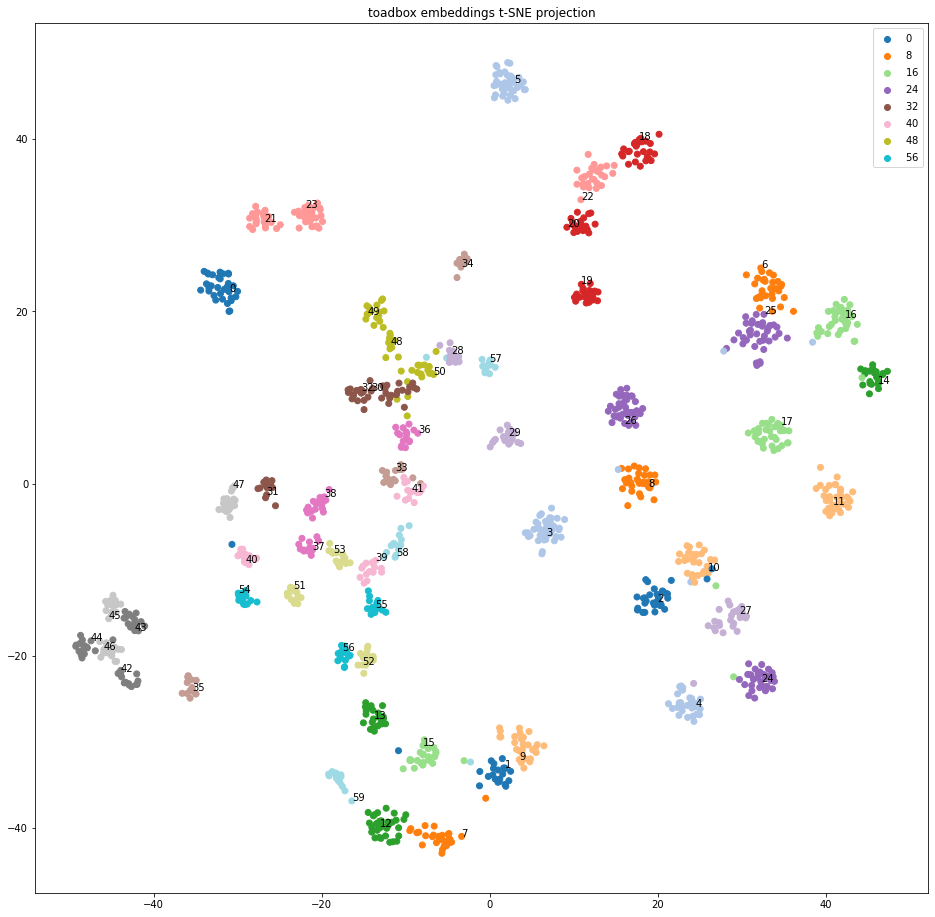

In [ ]:
plot_tsne(model, 'toadbox', transform=transform)

Baking embeddings!


  0%|          | 0/61 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


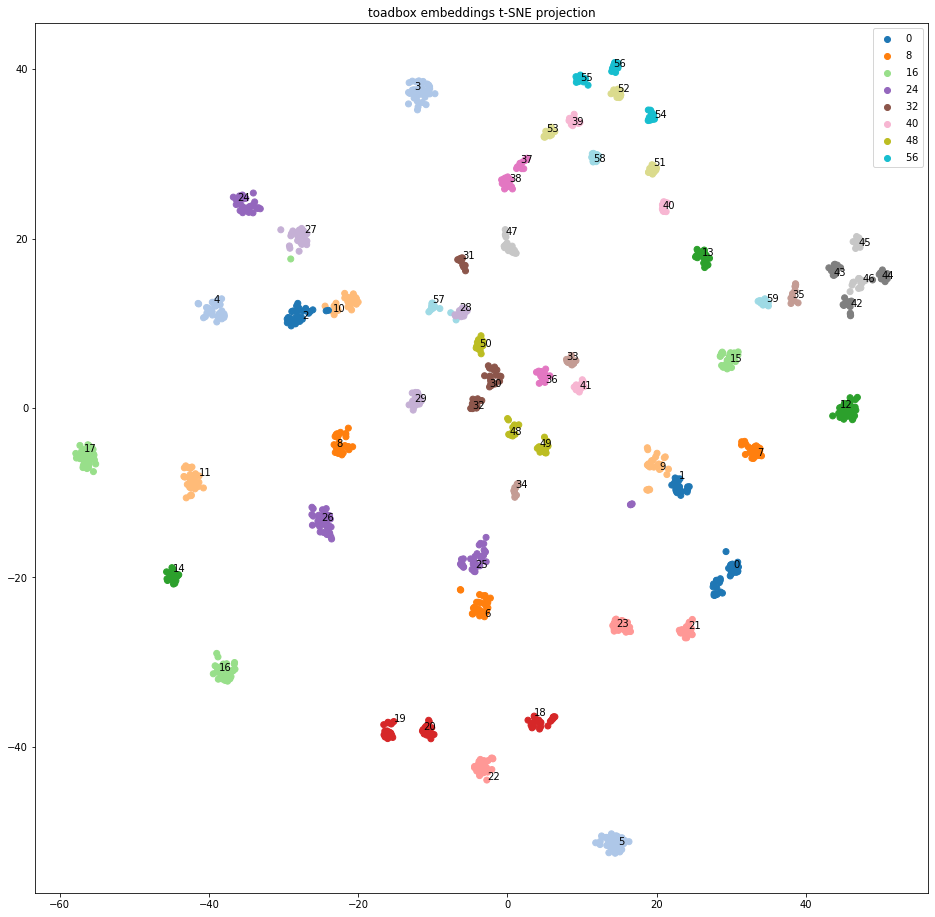

In [ ]:
plot_tsne(model, 'toadbox', transform=transform_test)

Baking embeddings!


  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


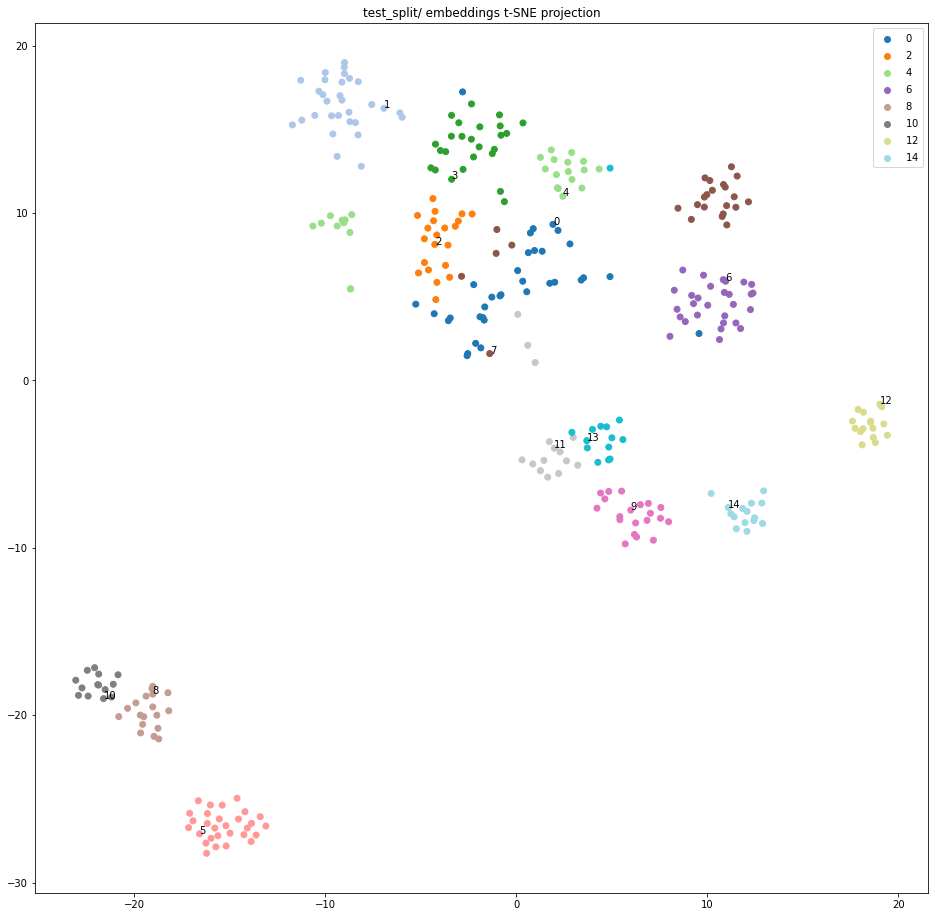

In [ ]:
plot_tsne(model, VALID_PATH, transform=transform)

Baking embeddings!


  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


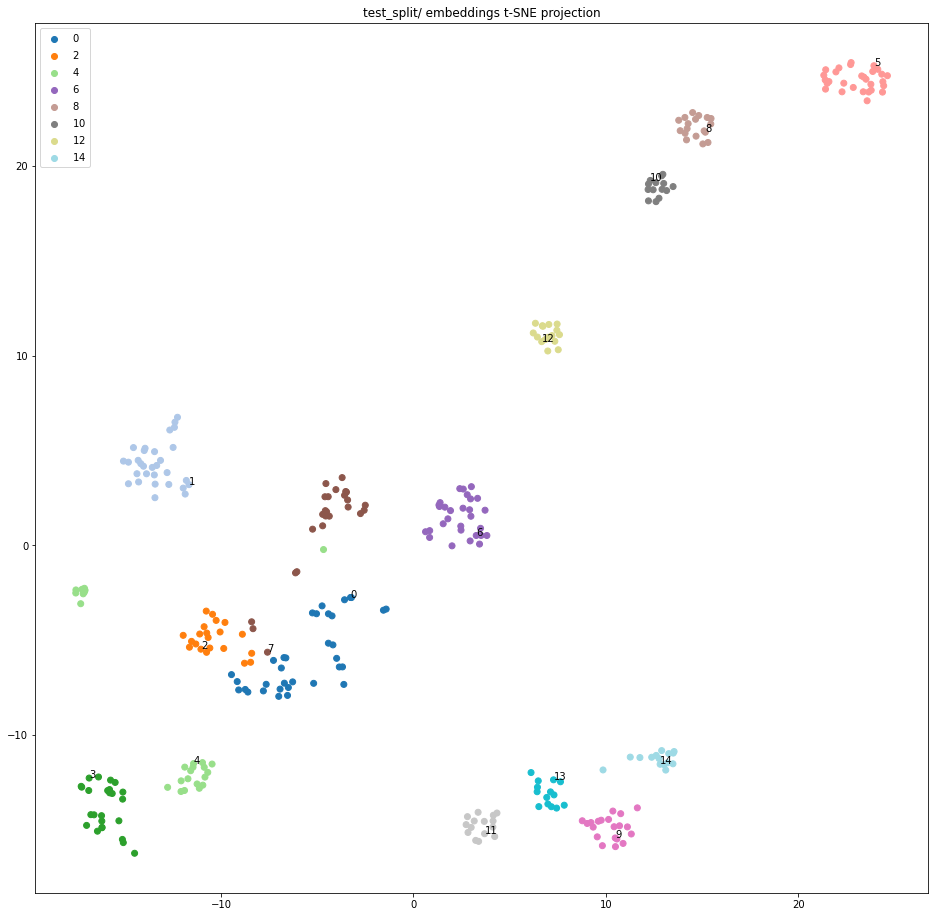

In [ ]:
plot_tsne(model, VALID_PATH, transform=transform_test)

In [ ]:
#torch.save(model.state_dict(), '/content/drive/MyDrive/toad-54.pth')
#model.load_state_dict(torch.load('/content/drive/MyDrive/toadid_new_23_11_2022.pth', map_location=torch.device('cpu')))

In [ ]:
!ls

all  drive  sample_data  test_split  toadbox  toadbox.zip  wandb


In [ ]:
model ;

In [ ]:
for p in model.backbone.layer3.parameters():
    p.requires_grad = True

In [ ]:
toads = np.array(glob(f'/content/all/t1/*'))

for t in toads:
    plt.imshow(transform_test(Image.open(t)).permute(1,2,0))
    plt.show()

In [ ]:
toads

array([], dtype=float64)

all  drive  sample_data  test_split  toadbox  toadbox.zip  wandb


## YOLO inference

In [ ]:
!pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

     |████████████████████████████████| 1.6 MB 48.2 MB/s 


In [ ]:
!cp -r /content/drive/MyDrive/toadid_detection/18112022_all/weights/best.pt yolo_model.pt

In [ ]:
yolo_model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolo_model.pt')

/usr/local/lib/python3.7/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  "You are about to download and run code from an untrusted repository. In a future release, this won't "
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-11-29 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 1

In [ ]:
def crop_save(ds_path, outdir='toadbox_crop'):
    for t in tqdm(os.listdir(ds_path)):
        batch_names = os.listdir(os.path.join(ds_path, t))
        crop_names = [os.path.join(outdir, t, x) for x in batch_names]
        for dir in [os.path.join(outdir, t) for x in batch_names]:
            os.makedirs(dir, exist_ok=True)
        batch_names = [os.path.join(ds_path, t, x) for x in batch_names]
        preds = yolo_model(batch_names)

        for name, crop_name, bboxes in zip(batch_names, crop_names, preds.xyxy):
            if len(bboxes) == 0:
                print(f'{name} empty!')
                continue
            best_pred = sorted(bboxes, key=lambda bbox: bbox[4], reverse=True)[0]
            bbox = best_pred[:4].tolist()
            crop = Image.open(name).crop((*bbox, ))
            crop.save(crop_name)

In [ ]:
def crop_best(yolo_out):
    best_score = 0
    img = None
    yolo_out = yolo_out.crop(save=False)
    for crop in yolo_out:
        score = crop['conf'].item()
        if score > best_score:
            best_score = score
            img = crop['im']
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = Image.fromarray(img)
    return img

In [ ]:
def yolo_process(sample):
    out = yolo_model(sample)
    img = crop_best(out)
    return img